In [13]:
import os
import random
import math

import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/vr1059/self-driving-data/data'
annotation_csv = '/scratch/vr1059/self-driving-data/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 128)
val_labeled_scene_index = np.arange(128, 132)
test_labeled_scene_index = np.arange(132, 134)

In [14]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [15]:
class_label = 1
class_dict = dict()
reverse_class_dict = []
reverse_class_dict.append((-100, -100))
for i in range(400, 800, 50):
    for j in range(100, 600, 50):
        class_dict[(i, j)] = class_label
        class_label += 1
        reverse_class_dict.append((i, j))
        
class_dict[(-100, -100)] = 0

In [16]:
def round_up(x):
    return int(math.ceil(x / 50.0)) * 50

def round_down(x):
    return round_up(x) - 50

In [17]:
def front_collate_fn(batch):
    front_imgs = []
    front_right_imgs = []
    front_left_imgs = []
    target = []
    road_imgs = []
    bbs = []
    for x in batch:
        # input
        front_left_imgs.append(torch.tensor(x[0][0]))
        front_imgs.append(torch.tensor(x[0][1]))
        front_right_imgs.append(torch.tensor(x[0][2]))
        road_imgs.append(torch.tensor(x[2]))
        
        # target
        bb_tens = x[1]['bounding_box']
        bbs.append(bb_tens)
        x_min = 800
        bb_cand = (-100, -100)
        
        for i, corners in enumerate(bb_tens):
            # Get bird's eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            if xs[2] - xs[0] > 5:
                top_center_x, top_center_y = 0.5*(xs[2] + xs[3]), 0.5*(ys[2] + ys[3])
            else:
                top_center_x, top_center_y = 0.5*(xs[0] + xs[1]), 0.5*(ys[0] + ys[1])
                
            # We do (800 - top_center_y) because matplotlib y-axis starts from the top. 
            v1 = np.array([top_center_x - 400, 800 - top_center_y - 400])
            v2 = np.array([2, 0])
            
            if abs(angle_between(v1, v2)) <= 35 and x[1]['category'][i] not in [1, 3, 6, 8]:
                if top_center_x < x_min:
                    x_min = top_center_x
                    bb_cand = (top_center_x.item(), top_center_y.item())
         
        if int(bb_cand[0]) == -100:
            target.append((0, bb_cand[0], bb_cand[1]))
        else:
            key = (round_down(bb_cand[0]), round_down(bb_cand[1]))
            if key not in class_dict:
                print(bb_cand)
            label = class_dict[key]
            target.append((label, bb_cand[0], bb_cand[1]))
                
    boom = torch.stack(front_imgs), torch.tensor(target), torch.stack(road_imgs), bbs, torch.stack(front_right_imgs), torch.stack(front_left_imgs)
    return boom

In [18]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
val_transform = transforms.ToTensor()
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.5, contrast = 0.3, saturation = 0.2, hue = (-0.3, 0.3)),
        transforms.RandomAffine(10),
    ]),
    transforms.ToTensor(),
])
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=48, shuffle=True, collate_fn=front_collate_fn)
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=48, shuffle=False, collate_fn=front_collate_fn)


In [19]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        
        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(512, 81)),
        ]))
        
#         self.regression.linear1.bias = nn.Parameter(torch.tensor(400.))
        
    def forward(self, x):
        x = self.encoder(x)
        return self.classification(x)
    
model = SimpleModel()

In [421]:
device = torch.device('cpu')
model.load_state_dict(torch.load('best_val_loss_simple.pt', map_location=device))

<All keys matched successfully>

In [422]:
import pdb

In [423]:
model.eval()
correct = 0
total = 0 
val_losses = []
criterion = nn.CrossEntropyLoss()
for i, (sample, target, road_img, bbs, front_right, front_left) in enumerate(val_loader):

    model.eval()

    sample = sample.to(device)
    target = target.to(device)

    with torch.no_grad():
        target = target[:, 0]
        y_hat = model(sample)
        preds = torch.argmax(y_hat, dim=1)
        for i, x in enumerate(preds):
            if int(x) == int(target[i]):
                correct += 1
        total += y_hat.shape[0]
        loss = criterion(y_hat, target.long())

        val_losses.append(loss.item())

#         if i % 5 == 0:
#             print('Val Epoch: {} [{}/{} ({:.0f}%)]\tAverage Loss So Far: {:.6f}'.format(
#                 epoch, i * len(sample), len(val_loader.dataset),
#                 5. * i / len(val_loader), np.mean(val_losses)))

print("Average Val Loss: ", np.mean(val_losses))
print("\n Val Accuracy: ", 100.*correct/total)

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

Average Val Loss:  2.2703144279393284

 Val Accuracy:  45.833333333333336


In [282]:
labeled_testset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=test_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

test_loader = torch.utils.data.DataLoader(labeled_testset, batch_size=32, shuffle=True, collate_fn=front_collate_fn)

In [283]:
sample, target, road_img, bbs, front_right, front_left = iter(test_loader).next()
model_preds = model(sample)

/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/vr1059/py3.6.3/lib/python3.6/site-packages/ip

In [284]:
model_preds

tensor([[ 0.2574, -3.3898, -3.2317,  ..., -2.2177, -1.7610, -1.8231],
        [-1.8413, -2.8963, -3.1251,  ..., -2.3799, -1.6830, -1.8082],
        [-0.0935, -3.6019, -3.3769,  ..., -2.4343, -1.9166, -1.9050],
        ...,
        [ 0.5836, -2.8546, -2.8650,  ..., -2.0950, -1.3513, -1.4719],
        [ 0.3732, -3.3522, -3.1885,  ..., -2.2708, -1.5699, -1.7871],
        [-1.6451, -3.9107, -3.2102,  ..., -2.8759, -1.9957, -2.5448]],
       grad_fn=<AddmmBackward>)

In [285]:
idx = -1

In [416]:
idx += 1

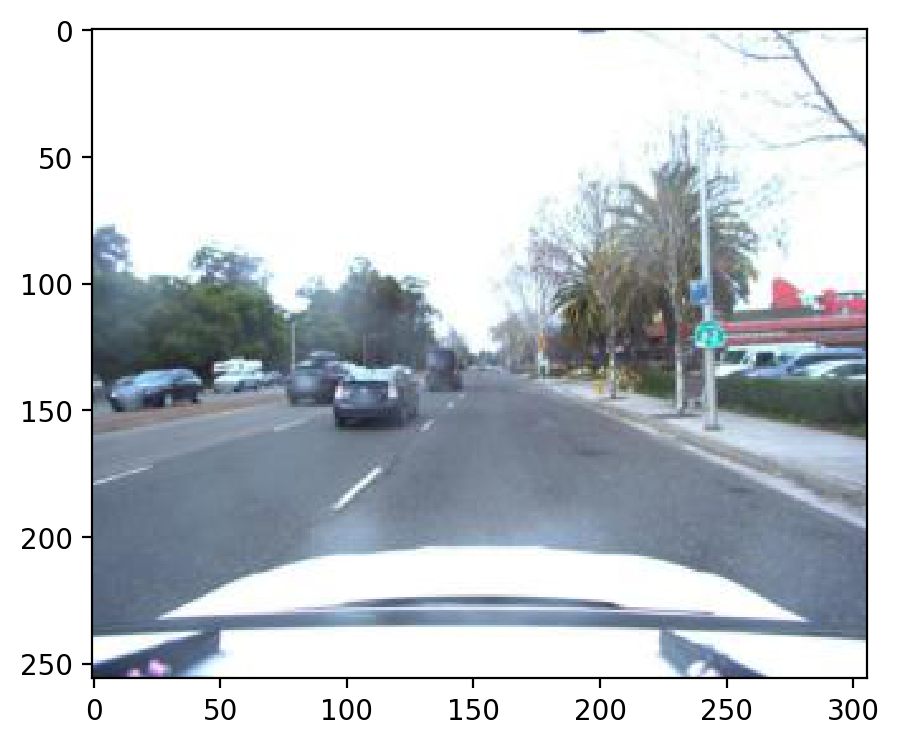

In [417]:
plt.imshow(sample[idx].numpy().transpose(1, 2, 0))

In [418]:
predicted = torch.argmax(model_preds[idx]).item()
print(predicted)
print(int(target[idx][0].item()))

46
36


In [419]:
model_preds[idx]

tensor([-1.7381, -3.6330, -3.8555, -3.5025, -3.0573, -4.0448, -0.0273, -1.0315,
        -5.0307, -4.1308, -4.2385, -3.4573, -4.6520, -4.5196, -3.6506, -0.5551,
         0.8895,  0.1729, -1.3852, -3.6591, -3.8759, -2.8629, -3.9796, -4.4670,
        -3.4454,  1.7586,  2.1837, -0.6413,  1.0984, -2.4111, -4.3001, -3.5363,
        -4.0963, -4.3557,  1.4219,  0.9025,  3.7329, -0.0119,  1.6034,  1.2057,
        -3.5038, -3.6249, -4.0888, -1.8546,  2.2569,  1.2729,  4.1542,  0.2772,
        -0.4832,  1.3897, -1.4827, -4.7101, -2.7956, -0.4495,  0.2509, -0.6610,
         2.1831, -1.1626, -1.2558, -2.4884, -1.8802, -4.4424, -2.8107, -1.8445,
        -1.1815, -1.2709,  1.3842, -1.9225, -3.9416, -1.7930, -0.9825, -5.1478,
        -2.8761, -2.9361, -3.1475, -1.0602,  0.5072, -1.2729, -2.7063, -1.9796,
        -2.1331], grad_fn=<SelectBackward>)

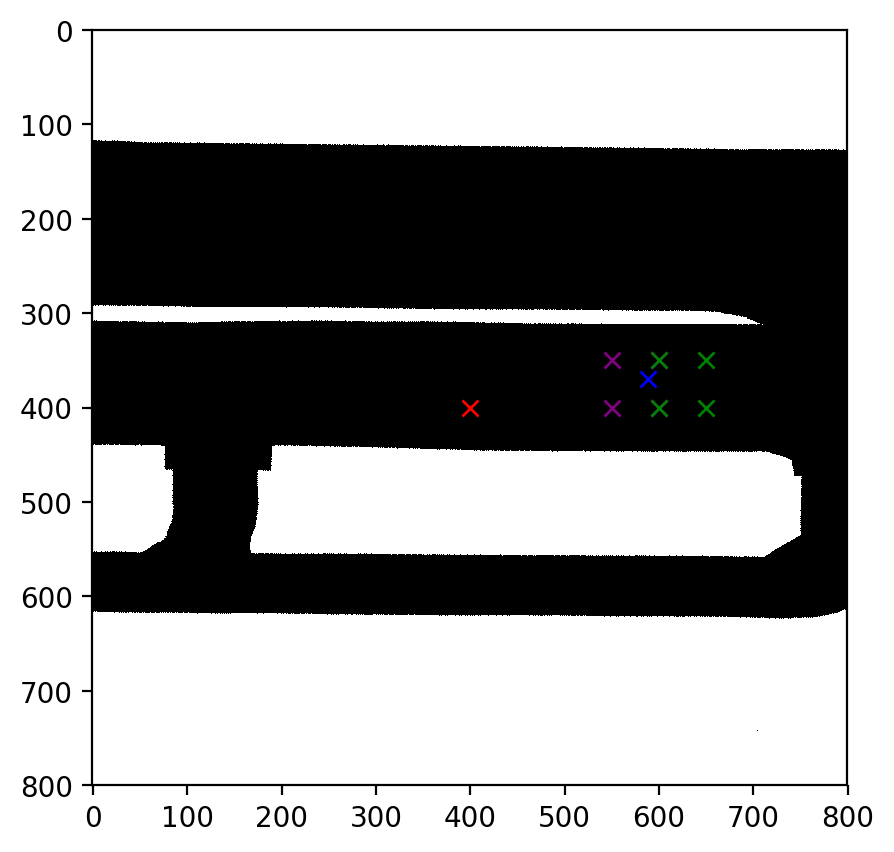

In [420]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][1], target[idx][2], 'x', color="blue")
class_box = reverse_class_dict[int(target[idx][0].item())]
box_xs = [class_box[0], class_box[0], class_box[0]+50, class_box[0]+50]
box_ys = [class_box[1], class_box[1]+50, class_box[1], class_box[1]+50]
ax.plot(box_xs, box_ys, 'x', color="purple")
predicted_box = reverse_class_dict[int(predicted)]
box_xs = [predicted_box[0], predicted_box[0], predicted_box[0]+50, predicted_box[0]+50]
box_ys = [predicted_box[1], predicted_box[1]+50, predicted_box[1], predicted_box[1]+50]
ax.plot(box_xs, box_ys, 'x', color="green")